In [2]:
import sys
!git clone -b models/preprocessing https://github.com/duckysmacky/cogniflex.git
%cd cogniflex
%cd /kaggle/working/cogniflex
!pwd
!ls model
sys.path.insert(0, './model')

Cloning into 'cogniflex'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 61 (delta 8), reused 56 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (61/61), 208.15 KiB | 8.33 MiB/s, done.
Resolving deltas: 100% (8/8), done.
/kaggle/working/cogniflex
/kaggle/working/cogniflex
/kaggle/working/cogniflex
experiments.ipynb  preprocess_data.py  requirements.txt  visualizations.py


In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
from utils.preprocess_data import DeepfakeDataset, IMAGE_TRANSFORM_TRAIN, IMAGE_TRANSFORM_VAL, get_images_paths
from utils.visualizations import view_picture
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader
import torch

In [4]:
model_type_paths = ['imagenet_ai_0419_biggan', 'imagenet_ai_0508_adm', 'imagenet_glide']

images_paths_train, images_paths_val, labels_train, labels_val  = get_images_paths('/kaggle/input/datasets/yangsangtai/tiny-genimage')

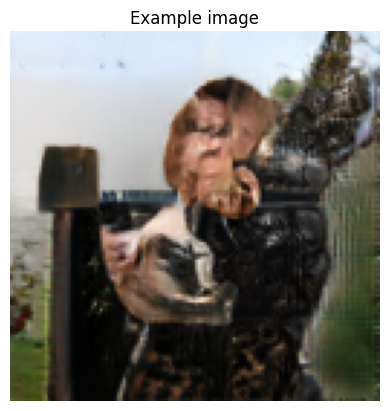

In [5]:
view_picture(images_paths_val[67])

In [6]:
dataset_train = DeepfakeDataset(images_paths_train, labels_train, transform=IMAGE_TRANSFORM_TRAIN)
dataset_test = DeepfakeDataset(images_paths_val, labels_val, transform=IMAGE_TRANSFORM_VAL)

train_loader = DataLoader(
    dataset_train ,
    batch_size=32,
    shuffle=True,
    num_workers=6) #set 4-8

val_loader = DataLoader(
    dataset_test,
    batch_size=32,
    shuffle = False,
    num_workers=2)

len(dataset_train), len(dataset_test)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


(12000, 3000)

In [ ]:
#THIS IS JUST A TEST MODEL WITH FROZEN LAYERS

# loading trained with ImageNet(~12m pictures) model with CNN(resnet) architecture
resnet = models.resnet18(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False

# last layer is replaced with linear layer with 2 outputs
resnet.fc = nn.Linear(resnet.fc.in_features, 2)
for param in resnet.fc.parameters():
    print(param.requires_grad)

optimizer = torch.optim.Adam(resnet.fc.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

resnet = resnet.to(device_pc)
print("Device:", device_pc)

/Users/iaroslav/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/iaroslav/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


True
True


In [12]:
device_pc = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
def train_model_with_early_stopping(num_epochs:int = 20):  

    criterion = nn.CrossEntropyLoss()
    #settings for early stopping
    best_val_loss = float('inf') 
    patience = 3                
    epochs_no_improve = 0         
    save_path = "best_resnet_fc.pth"

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}")
        resnet.train()
        train_loss = 0
        train_batches = 0

        for images, labels in train_loader:
            images = images.to(device_pc)
            labels = labels.to(device_pc)

            optimizer.zero_grad()
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_batches += 1
        
        avg_train_loss = train_loss/train_batches
        print(f"Train loss: {avg_train_loss:.4f}")

        resnet.eval()
        val_loss = 0
        correct = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device_pc)
                labels = labels.to(device_pc)

                outputs = resnet(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
        

        avg_val_loss = val_loss/len(val_loader.dataset)
        accuracy = correct / len(val_loader.dataset)
        scheduler.step()

        print(f"Val loss: {avg_val_loss:.4f}")
        print(f"Val acc: {accuracy:.4f}")

        # EARLY STOPPING
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            
            torch.save(resnet.state_dict(), save_path)
            print(f"Model saved at epoch {epoch+1}")
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print('There is no improvement')
            break


In [9]:
train_model_with_early_stopping()

NameError: name 'train_model_with_early_stopping' is not defined

In [16]:
resnet = models.resnet18(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = True

resnet.fc = nn.Linear(resnet.fc.in_features, 2)
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
resnet = resnet.to(device_pc)
print("Device:", device_pc)

Device: cuda


In [17]:
train_model_with_early_stopping(5)

Epoch 1
Train loss: 0.1408
Val loss: 0.0024
Val acc: 0.9783
Model saved at epoch 1
Epoch 2
Train loss: 0.0509
Val loss: 0.0019
Val acc: 0.9797
Model saved at epoch 2
Epoch 3
Train loss: 0.0416
Val loss: 0.0029
Val acc: 0.9693
Epoch 4
Train loss: 0.0210
Val loss: 0.0019
Val acc: 0.9837
Model saved at epoch 4
Epoch 5
Train loss: 0.0248
Val loss: 0.0018
Val acc: 0.9850
Model saved at epoch 5


In [20]:
!find /kaggle -name "*.pth"

/kaggle/working/cogniflex/best_resnet_fc.pth
